## Import packages

In [1]:
import datetime
from pathlib import Path
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils import check_integrity, load_data, datestring_to_timestamp, get_golden_timestamps, \
    my_fillna, check_integrity_score
import mplfinance as mpf
import datetime
import numpy as np
import seaborn as sns

plt.rcParams.update({'font.size': 12})


In [2]:
data_dir = Path(os.getcwd(), '..', 'data').resolve()
intervals = ['1D', '1W', '3h', '30m']
time_ranges = [("2021-04-12", "2021-06-15"), ("2021-08-16", "2021-10-18"), ("2021-01-04", "2021-11-29")]
timestamp_ranges = [tuple(map(datestring_to_timestamp, tup)) for tup in time_ranges]
coins_pass_check_1 = {}   # "2021-04-12" - "2021-06-14"
coins_pass_check_2 = {}  # "2021-08-16" - "2021-10-17"
coins_pass_check_3 = {}

for interval in intervals:
    coins_pass_check_1[interval] = []
    coins_pass_check_2[interval] = []
    coins_pass_check_3[interval] = []
    data_interval_dir = Path(data_dir, interval)
    files_path_list = [p for p in data_interval_dir.iterdir() if p.suffix == '.csv']
    for file_path in files_path_list:
        coin_code = file_path.name.split("_")[0]
        if check_integrity(*time_ranges[0], file_path) is not None:
            coins_pass_check_1[interval].append(coin_code)
        if check_integrity(*time_ranges[1], file_path) is not None:
            coins_pass_check_2[interval].append(coin_code)
        if check_integrity(*time_ranges[2], file_path) is not None:
            coins_pass_check_3[interval].append(coin_code)


In [3]:
print(f'The number of coins having all the data from {time_ranges[0][0]} to {time_ranges[0][1]}:')
print({k:len(v) for k, v in coins_pass_check_1.items()})
integrity_score_1 = check_integrity_score(time_ranges[0][0], time_ranges[0][1], coins_pass_check_1['1D'], data_dir)

The number of coins having all the data from 2021-04-12 to 2021-06-15:
{'1D': 112, '1W': 126, '3h': 67, '30m': 33}
The integrity score of 3h data: 0.9598823447507658
The integrity score of 30m data: 0.8660365626888569


In [4]:
print(f'The number of coins having all the data from {time_ranges[1][0]} to {time_ranges[1][1]}:')
print({k:len(v) for k, v in coins_pass_check_2.items()})
integrity_score_2 = check_integrity_score(time_ranges[1][0], time_ranges[1][1], coins_pass_check_2['1D'], data_dir)

The number of coins having all the data from 2021-08-16 to 2021-10-18:
{'1D': 131, '1W': 147, '3h': 3, '30m': 0}
The integrity score of 3h data: 0.9537449928198927
The integrity score of 30m data: 0.8505785123966941


In [5]:
print(f'The number of coins having all the data from {time_ranges[2][0]} to {time_ranges[2][1]}:')
print({k:len(v) for k, v in coins_pass_check_3.items()})
integrity_score_3 = check_integrity_score(time_ranges[2][0], time_ranges[2][1], coins_pass_check_3['1D'], data_dir)

The number of coins having all the data from 2021-01-04 to 2021-11-29:
{'1D': 72, '1W': 108, '3h': 1, '30m': 0}
The integrity score of 3h data: 0.9861111111111112
The integrity score of 30m data: 0.9193076046349647


**==>** Small granularity data has a large number of missing entries.

In [6]:
print(f'The number of coins having complete 1D data in the first two periods :')
coins = list(set(coins_pass_check_1['1D']).intersection(set(coins_pass_check_2['1D'])))
len(coins)

The number of coins having complete 1D data in the first two periods :


104

The following analysis will only focus on these coins.

The missing values of these coins will be filled with linear interpolation.

## Load data for further analysis

In [7]:
data_path = "../data"

data_1D_1_list = []
data_1D_2_list = []
data_1D_3_list = []
interval = '1D'

for coin in coins:
    file_path = Path(data_path, interval, f"{coin}_USD_{interval}.csv").resolve()
    data_1D_1_list.append(load_data(time_ranges[0][0], time_ranges[0][1], file_path, fill_na=True, price='open,close,high,low'))
    data_1D_2_list.append(load_data(time_ranges[1][0], time_ranges[1][1], file_path, fill_na=True, price='open,close,high,low'))
    data_1D_3_list.append(load_data(time_ranges[2][0], time_ranges[2][1], file_path, fill_na=False, price='open,close,high,low'))
data_1D_1 = pd.concat(data_1D_1_list)
data_1D_2 = pd.concat(data_1D_2_list)
data_1D_3 = pd.concat(data_1D_3_list)


In [8]:
data_1D_3['volumeUSD'] = data_1D_3['volume'] * data_1D_3['close']
h_vol = data_1D_3.groupby(level='coin').sum().volumeUSD.sort_values(ascending=False).index
l_vol = data_1D_3.groupby(level='coin').sum().volumeUSD.sort_values(ascending=True).index

## Stablecoins

In [9]:
with open('../stablecoin.txt', 'r') as fp:
    stablecoins = fp.readlines()
stablecoins = [s.strip() for s in stablecoins]

In [10]:
data_stable_list = []
for coin in stablecoins:
    file_path = Path(data_path, interval, f"{coin}_USD_1D.csv").resolve()
    data_stable_list.append(load_data(time_ranges[2][0], time_ranges[2][1], file_path, fill_na=False))

data_stable_df = pd.concat(data_stable_list)
data_stable_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2794 entries, (1609718400000, 'UST') to (1638144000000, 'XAUT')
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   close     2794 non-null   float64            
 1   volume    2794 non-null   float64            
 2   datetime  2794 non-null   datetime64[ns, UTC]
 3   is_fill   2794 non-null   bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(2)
memory usage: 87.6+ KB


In [11]:
stablecoins_highvol = data_stable_df.groupby('coin').sum().volume.sort_values(ascending=False)[:5].index.to_list()

In [81]:
data_highvol_list = []
top_vol_not_stable = [c for c in h_vol if c not in stablecoins]
for coin in top_vol_not_stable:
    file_path = Path(data_path, interval, f"{coin}_USD_1D.csv").resolve()
    data_highvol_list.append(load_data(time_ranges[2][0], time_ranges[2][1], file_path, fill_na=False))
data_highvol_df = pd.concat(data_highvol_list)
data_highvol_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2258 entries, (1609718400000, 'BTC') to (1638144000000, 'DOT')
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   close     2258 non-null   float64            
 1   volume    2258 non-null   float64            
 2   datetime  2258 non-null   datetime64[ns, UTC]
 3   is_fill   2258 non-null   bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(2)
memory usage: 72.9+ KB


In [82]:
data_lowvol_list = []
least_vol_not_stable = [c for c in l_vol if c not in stablecoins]
for coin in least_vol_not_stable:
    file_path = Path(data_path, interval, f"{coin}_USD_1D.csv").resolve()
    data_lowvol_list.append(load_data(time_ranges[2][0], time_ranges[2][1], file_path, fill_na=False))
data_lowvol_df = pd.concat(data_lowvol_list)
data_lowvol_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1521 entries, (1609718400000, 'PAS') to (1638144000000, 'VSY')
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   close     1521 non-null   float64            
 1   volume    1521 non-null   float64            
 2   datetime  1521 non-null   datetime64[ns, UTC]
 3   is_fill   1521 non-null   bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(2)
memory usage: 52.6+ KB


In [83]:
tmp_df = data_stable_df.append(data_highvol_df).append(data_lowvol_df)

In [107]:
_tmp_df.pct_change().abs()

timestamp      coin
1609718400000  PAS          NaN
1609804800000  PAS     0.127562
1609891200000  PAS     0.524625
1609977600000  PAS     0.358614
1610064000000  PAS     0.017518
                         ...   
1637798400000  PAS     0.118705
1637884800000  PAS     0.003039
1637971200000  PAS     0.071255
1638057600000  PAS     0.025253
1638144000000  PAS     0.040000
Name: close, Length: 330, dtype: float64

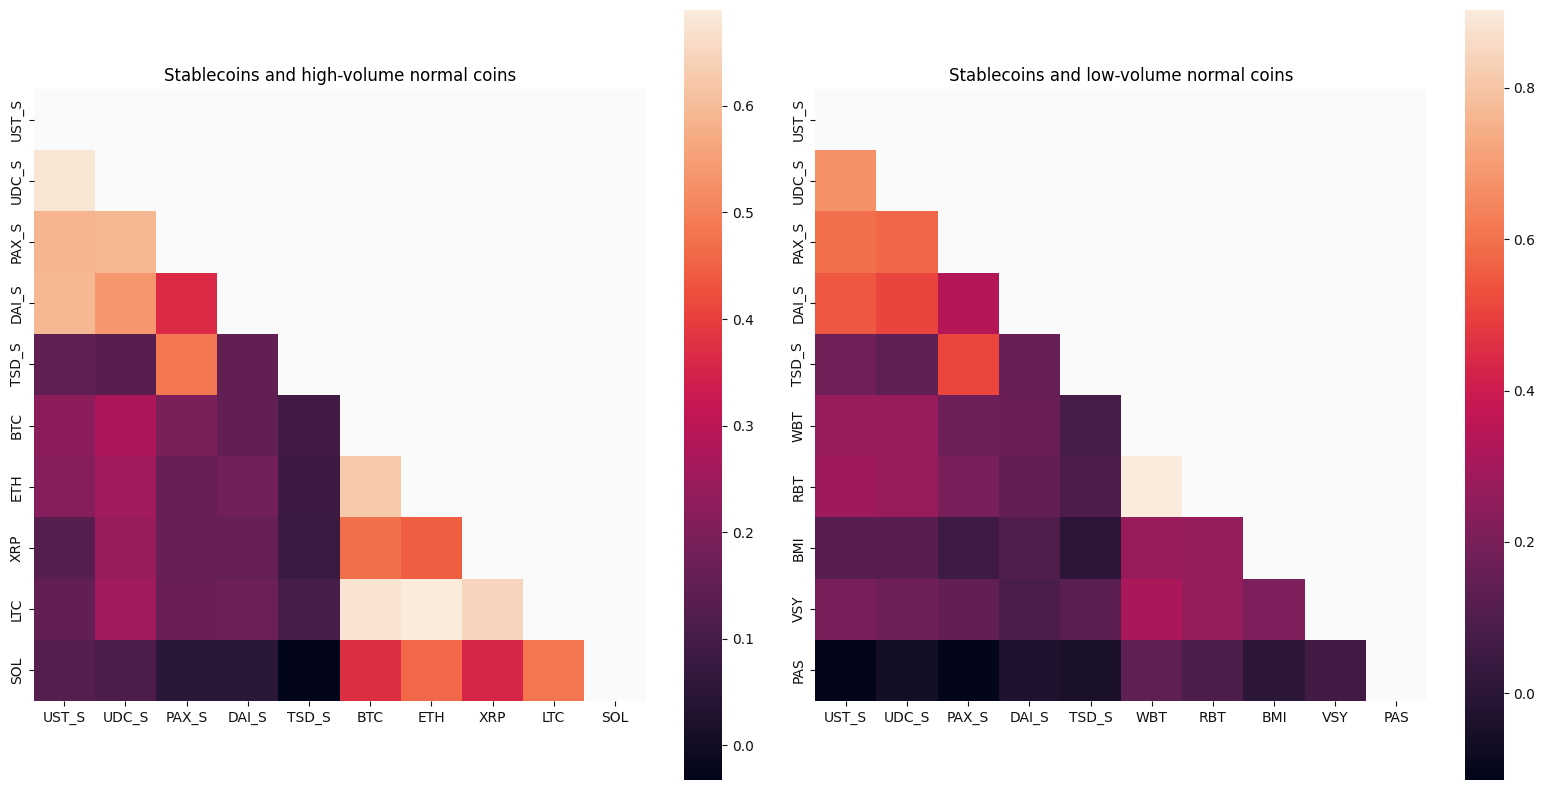

In [109]:
start, end = time_ranges[2][0],time_ranges[2][1]
_golden_timestamps = get_golden_timestamps(start, end, '1D')

least_vol_not_stable = data_lowvol_df[data_lowvol_df.index.isin(least_vol_not_stable, level='coin')].groupby('coin').sum().volume.sort_values(ascending=True)[:5].index.to_list()

_highvol_df_list = []
_lowvol_df_list = []
for tick in [*stablecoins_highvol, *top_vol_not_stable[:5], *least_vol_not_stable[:5]]:
    tick_label = tick if tick not in stablecoins else tick+'_S'
    _tmp_df = tmp_df[tmp_df.index.get_level_values('coin') == tick].copy()
    _tmp_df = my_fillna(_tmp_df, _golden_timestamps, ['close'])['close'].pct_change().abs().dropna()
    if tick in [*stablecoins_highvol, *top_vol_not_stable[:5]]:
        _highvol_df_list.append(_tmp_df.droplevel('coin').rename(tick_label))
    if tick in [*stablecoins_highvol, *least_vol_not_stable[:5]]:
        _lowvol_df_list.append(_tmp_df.droplevel('coin').rename(tick_label))
_highvol_df = pd.concat(_highvol_df_list, axis=1).dropna(axis=0)
_lowvol_df = pd.concat(_lowvol_df_list, axis=1).dropna(axis=0)
maskh = np.zeros_like(_highvol_df.corr())
maskh[np.triu_indices_from(maskh)] = True
maskl = np.zeros_like(_lowvol_df.corr())
maskl[np.triu_indices_from(maskl)] = True

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs.ravel()
sns.heatmap(_highvol_df.corr(), mask=maskh, annot=False, square=True, ax=axs[0])
# axs[0].set_title(f'Correlation heatmap between high-volume stablecoins and other high-volume coins\nTime range: {start} to {end}\n(Stablecoins have _S in their labels)')
axs[0].set_title(f'Stablecoins and high-volume normal coins')
sns.heatmap(_lowvol_df.corr(), mask=maskl, annot=False, square=True, ax=axs[1])
# axs[1].set_title(f'Correlation heatmap between high-volume stablecoins and low-volume normal coins\nTime range: {start} to {end}\n(Stablecoins have _S in their labels)')
axs[1].set_title(f'Stablecoins and low-volume normal coins')
plt.tight_layout()
plt.show()

## Time Series Visualization

In [86]:
interval_1D = '1D'
data_btc_etc_list = []
for coin in ['BTC', 'ETC']:
    file_path = Path(data_path, interval_1D, f"{coin}_USD_{interval_1D}.csv").resolve()
    data_btc_etc_list.append(load_data('2021-01-01', '2021-12-01', file_path, fill_na=True, price='open,close,high,low'))

data_btc_etc_df = pd.concat(data_btc_etc_list)

In [87]:
idx_list = []
for i in [0, 1]:
    for j in [0, 1]:
        idx_list.append(np.where(data_btc_etc_df[data_btc_etc_df.index.get_level_values('coin') == 'BTC'].datetime.values == np.datetime64(time_ranges[i][j]))[0])


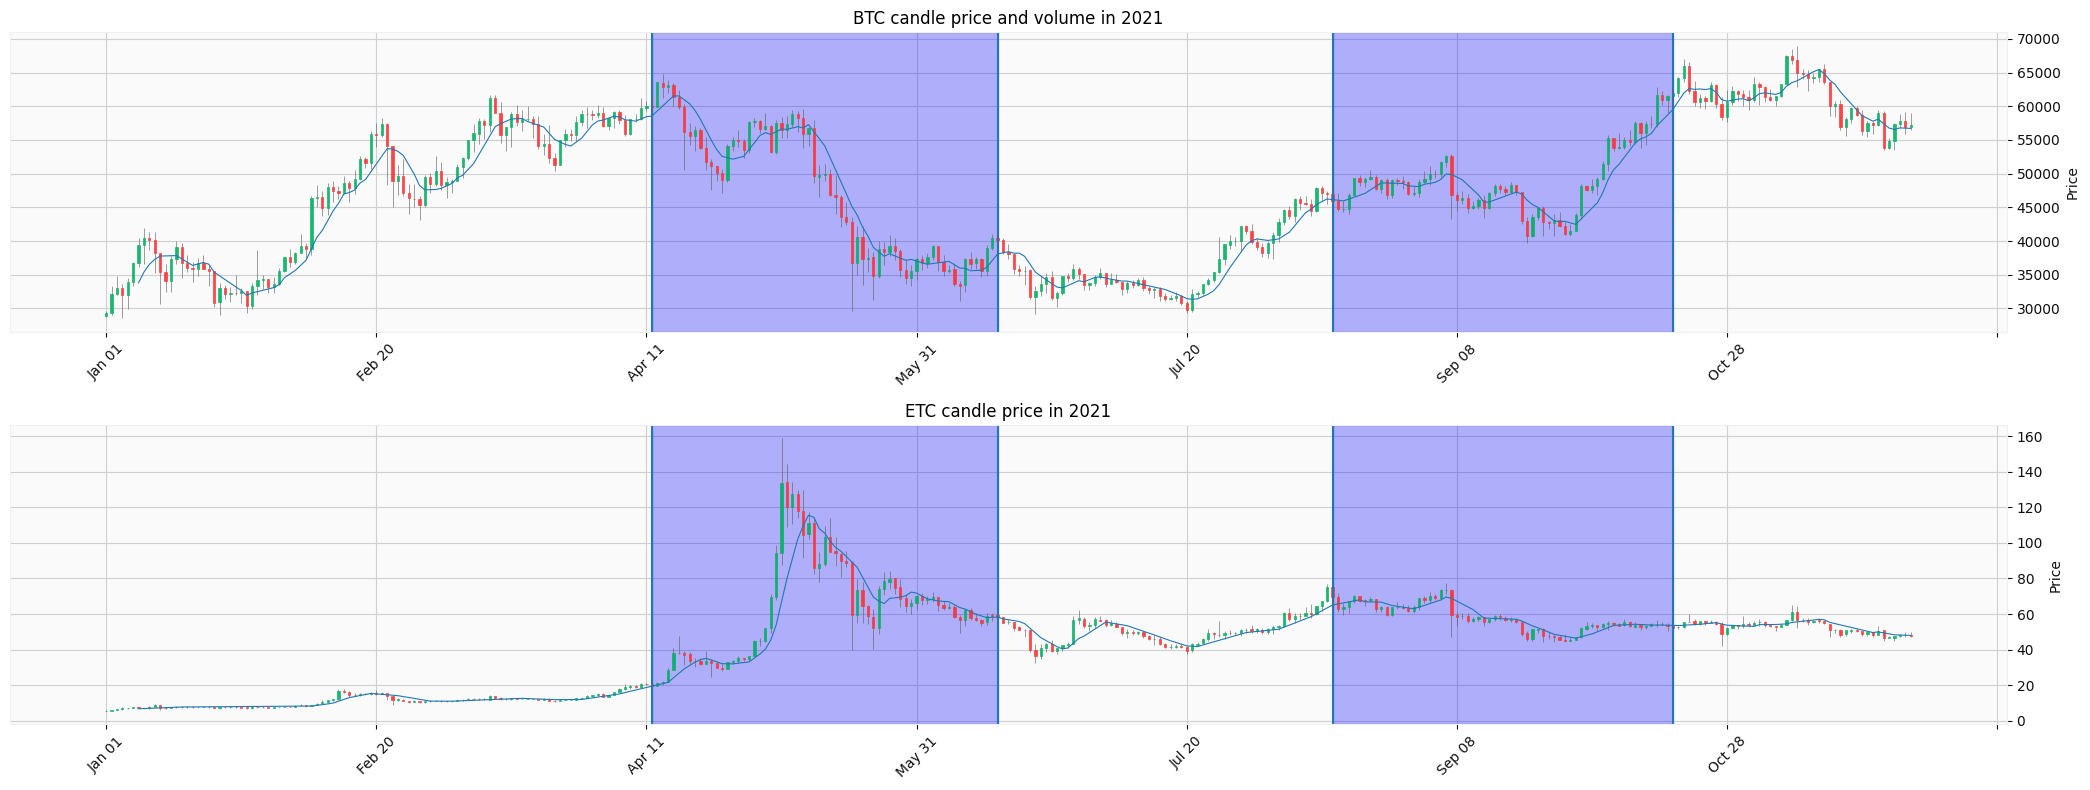

In [88]:
%matplotlib inline

# BTC candle price in 2021
fig = mpf.figure(figsize=(21,8))
ax1 = fig.add_subplot(2, 1, 1, style='yahoo')
for idx in idx_list:
    ax1.axvline(x=idx, ymin=0, ymax=1)
ax1.axvspan(int(idx_list[0]), int(idx_list[1]), alpha=0.3, color='blue')
ax1.axvspan(int(idx_list[2]), int(idx_list[3]), alpha=0.3, color='blue')
mpf.plot(data_btc_etc_df[data_btc_etc_df.index.isin(['BTC'], level='coin')].set_index('datetime'), type='candle', mav=7, ax=ax1, axtitle='BTC candle price and volume in 2021')
ax2 = fig.add_subplot(2, 1, 2, style='yahoo')
for idx in idx_list:
    ax2.axvline(x=idx, ymin=0, ymax=1)
ax2.axvspan(int(idx_list[0]), int(idx_list[1]), alpha=0.3, color='blue')
ax2.axvspan(int(idx_list[2]), int(idx_list[3]), alpha=0.3, color='blue')
mpf.plot(data_btc_etc_df[data_btc_etc_df.index.isin(['ETC'], level='coin')].set_index('datetime'), type='candle', mav=7, ax=ax2, axtitle='ETC candle price in 2021')
plt.tight_layout()
mpf.show()

The areas with the blue background are the time periods we will focus on.

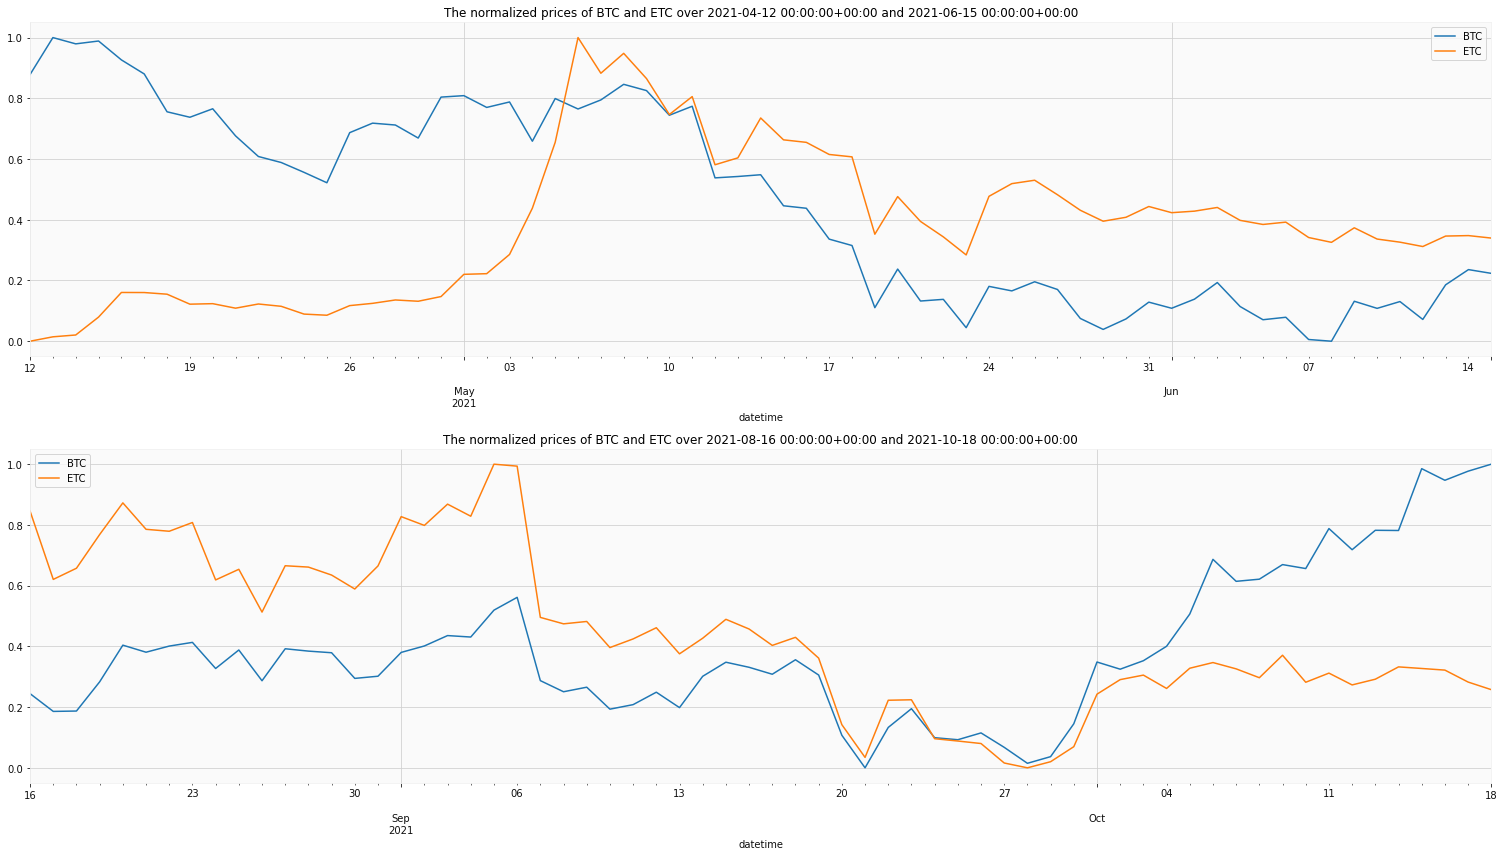

In [31]:
%matplotlib inline

fig, axs = plt.subplots(2, 1, figsize=(21, 12))
axs = axs.ravel()

plot_coins_num = 5
subplot_idx = 0
for df in [data_1D_1, data_1D_2]:
    for tick in ['BTC', 'ETC']:
        _tmp_df = df[df.index.get_level_values('coin') == tick].set_index('datetime').copy()
        for price_col in ['open', 'close', 'high', 'low']:
            scaler = MinMaxScaler()
            _tmp_df[price_col] = scaler.fit_transform(_tmp_df[[price_col]])
        _tmp_df['close'].plot(label=tick, ax=axs[subplot_idx])
    axs[subplot_idx].legend()
    axs[subplot_idx].set_title(f'The normalized prices of BTC and ETC over {min(df.datetime)} and {max(df.datetime)}')
    subplot_idx += 1

fig.tight_layout()
plt.show()

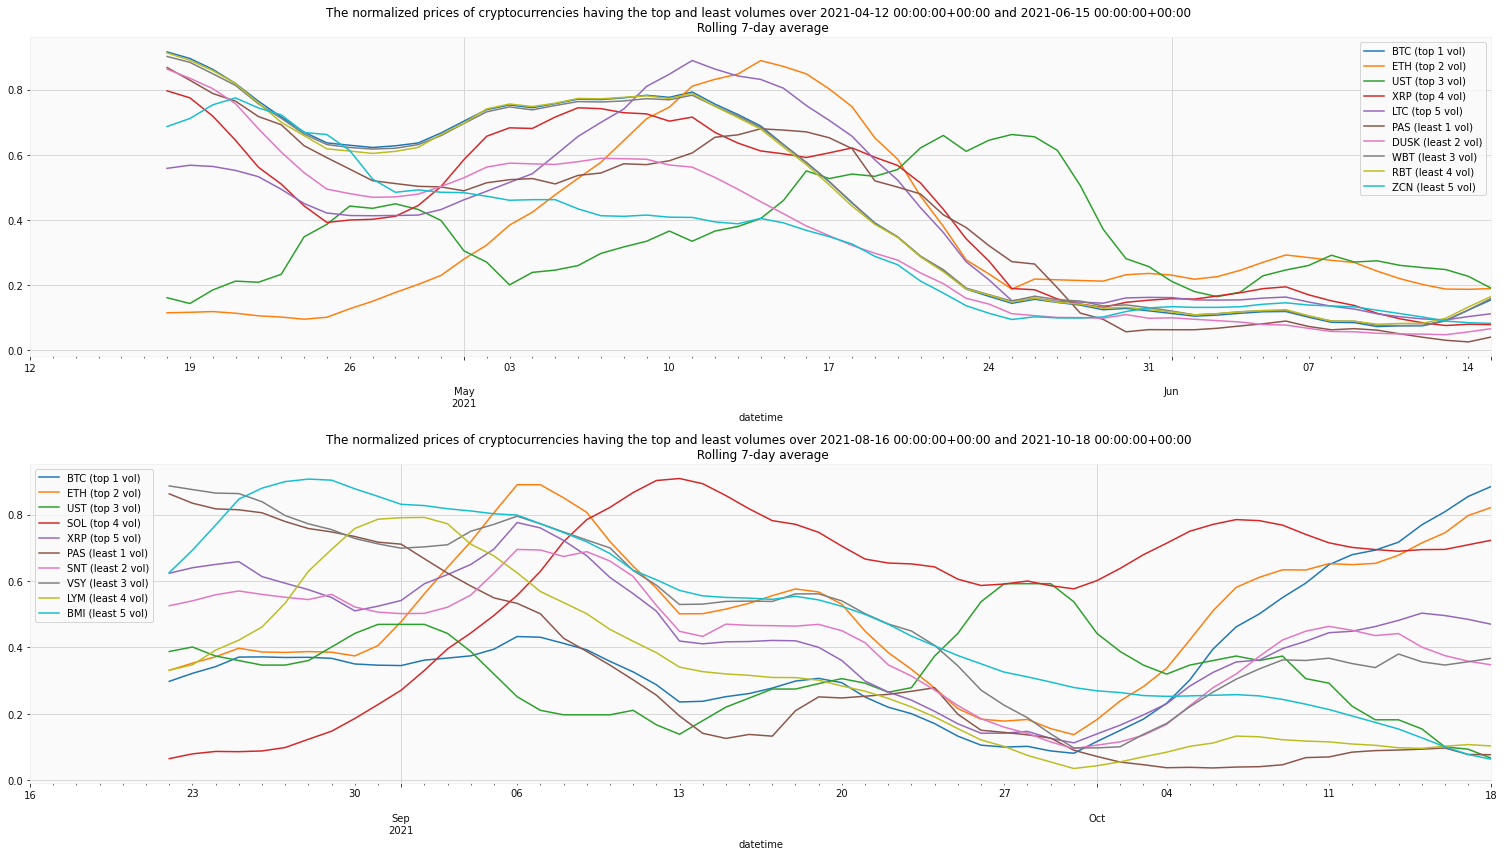

In [32]:
%matplotlib inline

fig, axs = plt.subplots(2, 1, figsize=(21, 12))
axs = axs.ravel()
top_vol_all = []
least_vol_all = []
subplot_idx = 0
for df in [data_1D_1, data_1D_2]:
    df['volumeUSD'] = df['volume'] * df['close']
    top_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=False).index[:plot_coins_num]
    top_vol_all.extend(top_vol)
    least_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=True).index[:plot_coins_num]
    least_vol_all.extend(least_vol)
    for idx, tick in enumerate(top_vol):
        scaler = MinMaxScaler()
        _tmp_df = df[df.index.get_level_values('coin') == tick].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df['price_std'].rolling(window=7).mean().plot(label=tick+f" (top {idx+1} vol)", ax=axs[subplot_idx])
    for idx, tick in enumerate(least_vol):
        scaler = MinMaxScaler()
        _tmp_df = df[df.index.get_level_values('coin') == tick].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df['price_std'].rolling(window=7).mean().plot(label=tick+f" (least {idx+1} vol)", ax=axs[subplot_idx])
    axs[subplot_idx].legend()
    axs[subplot_idx].set_title(f'The normalized prices of cryptocurrencies having the top and least volumes over {min(df.datetime)} and {max(df.datetime)} \n Rolling 7-day average')
    subplot_idx += 1
fig.tight_layout()
plt.show()

top_vol_all = list(set(top_vol_all))
least_vol_all = list(set(least_vol_all))
vol_concern = list({*least_vol_all, *top_vol_all})

## Market Volatility (price drawdown)

In [90]:
data_vola_list = []
for coin in [*top_vol_not_stable[:8], *least_vol_not_stable[:8]]:
    file_path = Path(data_path, '1D', f"{coin}_USD_1D.csv").resolve()
    _tmp_df = load_data(time_ranges[2][0],
                        time_ranges[2][1],
                        file_path,
                        fill_na=True,
                        price='close').reset_index().set_index(['datetime', 'coin'])[['close', 'volume']].pct_change().abs().rename(
        columns={"close": "close_diff", "volume": "volume_diff", "timestamp": "timestamp_diff"}
    )
    data_vola_list.append(_tmp_df)
data_vola_df = pd.concat(data_vola_list).dropna()
data_vola_df['week'] = data_vola_df.index.get_level_values('datetime').to_series().apply(lambda x: x.isocalendar()[1]).values

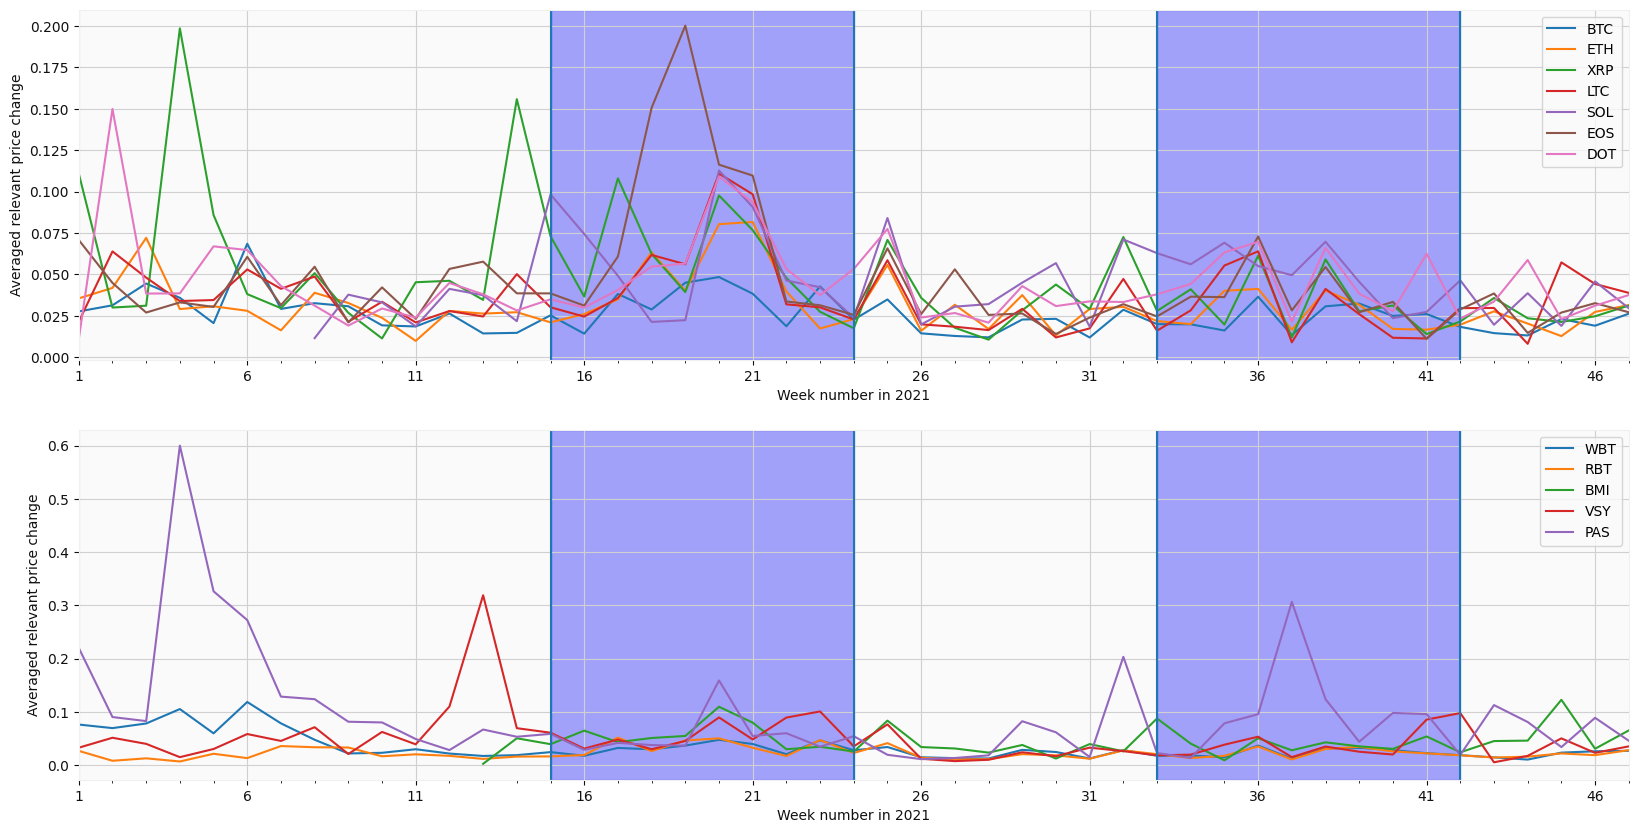

In [110]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
axs.ravel()

idx = 0
for concern_list in [top_vol_not_stable[:8], least_vol_not_stable[:8]]:
    for tick in concern_list:
        # scaler = MinMaxScaler(feature_range=(-1, 1))
        _tmp_df = data_vola_df[data_vola_df.index.get_level_values('coin') == tick].copy()
        # _tmp_df['normalized_price_dropdown'] = scaler.fit_transform(_tmp_df[['close_diff']])
        _tmp_df.groupby('week').std()['close_diff'].plot(label=tick, ax=axs[idx])
    axs[idx].legend()
    axs[idx].set_xticks(np.arange(1, max(_tmp_df.week), 5))
    axs[idx].set_xticks(np.arange(1, max(_tmp_df.week), 1), minor=True)
    # axs[idx].set_ylim([0., 0.25])
    axs[idx].set_xlim([1., 47])
    axs[idx].set_ylabel('Averaged relevant price change')
    axs[idx].set_xlabel('Week number in 2021')
    idx += 1

def day_to_week_2021(day):
    return 1 + (1 + day - 4) // 7


for j in idx_list:
    for i in range(idx):
        axs[i].axvline(x=day_to_week_2021(j), ymin=0)
        axs[i].axvspan(int(day_to_week_2021(idx_list[0])), int(day_to_week_2021(idx_list[1])), alpha=0.1, color='blue')
        axs[i].axvspan(int(day_to_week_2021(idx_list[2])), int(day_to_week_2021(idx_list[3])), alpha=0.1, color='blue')

# axs[0].set_title('The weekly fluctuation of high-volume cryptocurrencies')
# axs[1].set_title('The weekly fluctuation of low-volume cryptocurrencies')
# axs[2].set_title('The weekly fluctuation of cryptocurrencies')
fig.savefig('high-vol-fluc.png')
plt.show()


## One-week fluctuation (the standard deviation of close price)

In [33]:
data_fluc_list = []
for coin in [*top_vol_not_stable, *least_vol_not_stable]:
    file_path = Path(data_path, '1D', f"{coin}_USD_1D.csv").resolve()
    data_fluc_list.append(load_data(time_ranges[2][0], time_ranges[2][1], file_path, fill_na=True, price='close'))
data_fluc_df = pd.concat(data_fluc_list)
data_fluc_df['week'] = data_fluc_df['datetime'].apply(lambda x: x.isocalendar()[1])

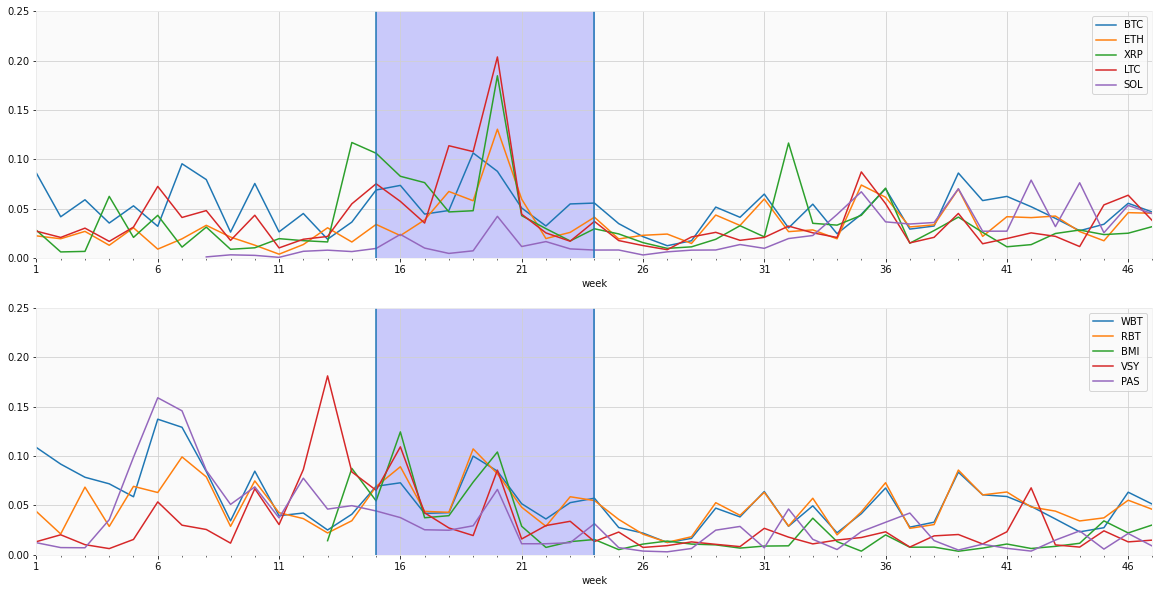

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
axs.ravel()

idx = 0
for concern_list in [top_vol_not_stable, least_vol_not_stable]:
    for tick in concern_list:
        scaler = MinMaxScaler()
        _tmp_df = data_fluc_df[data_fluc_df.index.get_level_values('coin') == tick].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df.groupby('week').std()['price_std'].plot(label=tick, ax=axs[idx])
    axs[idx].legend()
    axs[idx].set_xticks(np.arange(1, max(_tmp_df.week), 5))
    axs[idx].set_xticks(np.arange(1, max(_tmp_df.week), 1), minor=True)
    axs[idx].set_ylim([0., 0.25])
    axs[idx].set_xlim([1., 47])
    idx += 1

def day_to_week_2021(day):
    return 1 + (1 + day - 4) // 7


for j in idx_list[:2]:
    for i in range(idx):
        axs[i].axvline(x=day_to_week_2021(j), ymin=0)
        axs[i].axvspan(int(day_to_week_2021(idx_list[0])), int(day_to_week_2021(idx_list[1])), alpha=0.1, color='blue')
        # axs[i].axvspan(int(day_to_week_2021(idx_list[2])), int(day_to_week_2021(idx_list[3])), alpha=0.1, color='blue')

# axs[0].set_title('The weekly fluctuation of high-volume cryptocurrencies')
# axs[1].set_title('The weekly fluctuation of low-volume cryptocurrencies')
# axs[2].set_title('The weekly fluctuation of cryptocurrencies')
fig.savefig('high-vol-fluc.png')
plt.show()


## Close price correlation heatmap

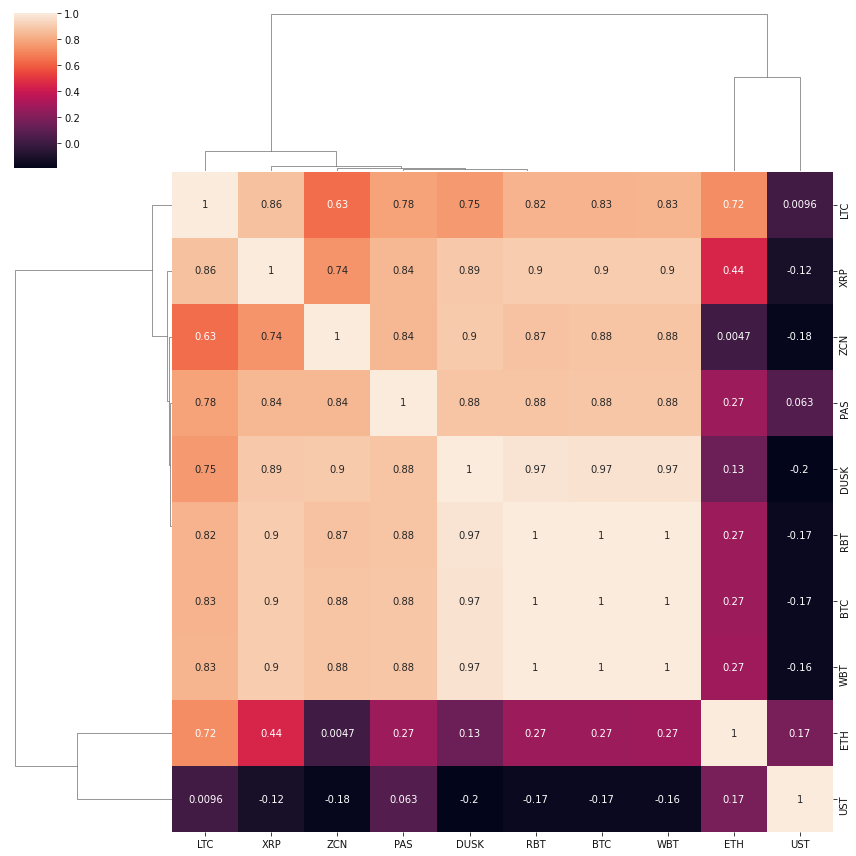

Volume high to low: ['BTC', 'ETH', 'UST', 'XRP', 'LTC', 'ZCN', 'RBT', 'WBT', 'DUSK', 'PAS']


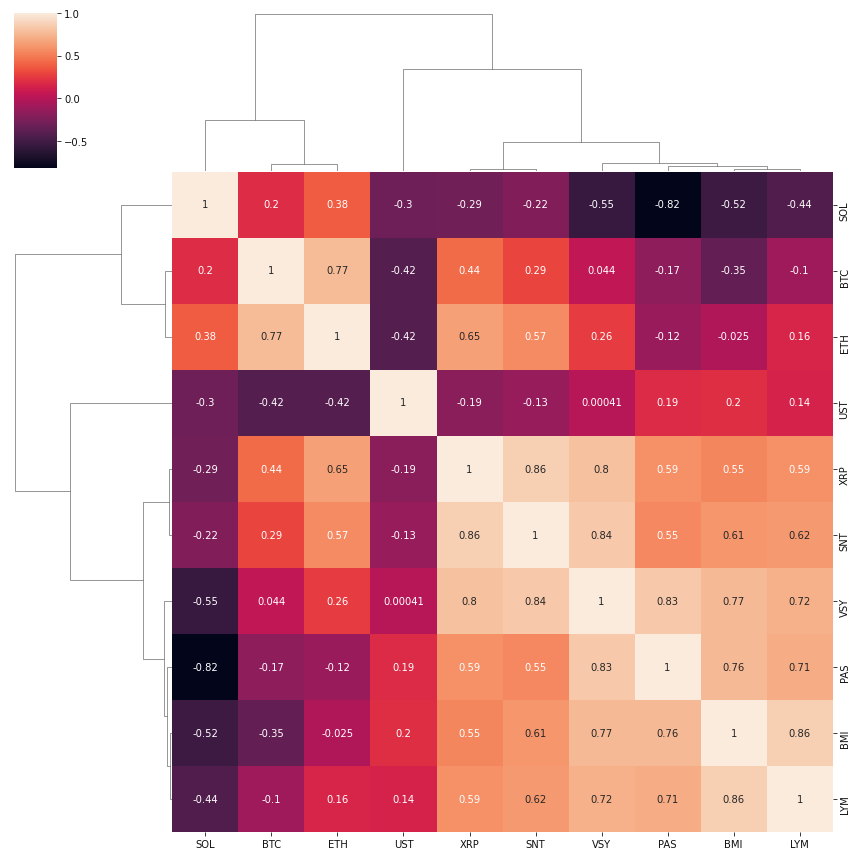

Volume high to low: ['BTC', 'ETH', 'UST', 'SOL', 'XRP', 'BMI', 'LYM', 'VSY', 'SNT', 'PAS']


In [15]:
%matplotlib inline

for df in [data_1D_1, data_1D_2]:
    _tmp_df_list = []
    df['volumeUSD'] = df['volume'] * df['close']
    top_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=False).index[:plot_coins_num].to_list()
    least_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=True).index[:plot_coins_num].to_list()
    least_vol.reverse()
    for tick in [*top_vol, *least_vol]:
        _tmp_df = df[df.index.get_level_values('coin') == tick].set_index('datetime').copy()['close'].rename(f'{tick}')
        _tmp_df_list.append(_tmp_df)
    _tmp_df = pd.concat(_tmp_df_list, axis=1)
    g = sns.clustermap(_tmp_df.corr(), metric='correlation', annot=True, figsize=(12,12))
    plt.show()
    print("Volume high to low: " + str([*top_vol, *least_vol]))